In [50]:
# Import relevant libraries and dataset
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score

ames = pd.read_csv("AmesHousing.csv")

In [51]:
# Clean the data
good_cols = ames.isna().sum() < 100
ames = ames.loc[:,good_cols]
ames = ames.dropna()

## 14.2: Ridge Regression

In [52]:
# Make pipeline that fits Ridge regression with λ=1
X = ames.drop(["SalePrice", "Order", "PID"], axis = 1)
y = ames["SalePrice"]


ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown="ignore"),
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

ridge_pipeline = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", Ridge(alpha=1.0))]
)

# Cross-validate
scores = cross_val_score(ridge_pipeline, X, y, cv = 5, scoring = "r2")
scores.mean()

0.8619316345217338

In [53]:
# Compare with linear regression
lr_pipeline = Pipeline(
    [("preprocessing", ct),
     ("linear_regression", LinearRegression())]
)

scores_lr = cross_val_score(lr_pipeline, X, y, cv = 5, scoring = "r2")
scores_lr.mean()

-7.243833902756543e+20


Clearly the Ridge regression model fits the data much better than the linear regression model. Not only is the Ridge model's mean R-squared value (0.86) close to 1, but the linear model's mean R-squared value is negative, indicating that it does not fit the data well at all.


In [54]:
# Fit both models on whole dataset and get coefficients

ridge_pipeline_fitted = ridge_pipeline.fit(X, y)
ridge_coefs = ridge_pipeline_fitted.named_steps["ridge_regression"].coef_

lr_pipeline_fitted = lr_pipeline.fit(X, y)
lr_coefs = lr_pipeline_fitted.named_steps["linear_regression"].coef_

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
/usr/local/lib/python3.10/dist-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 108 rows containing missing values.


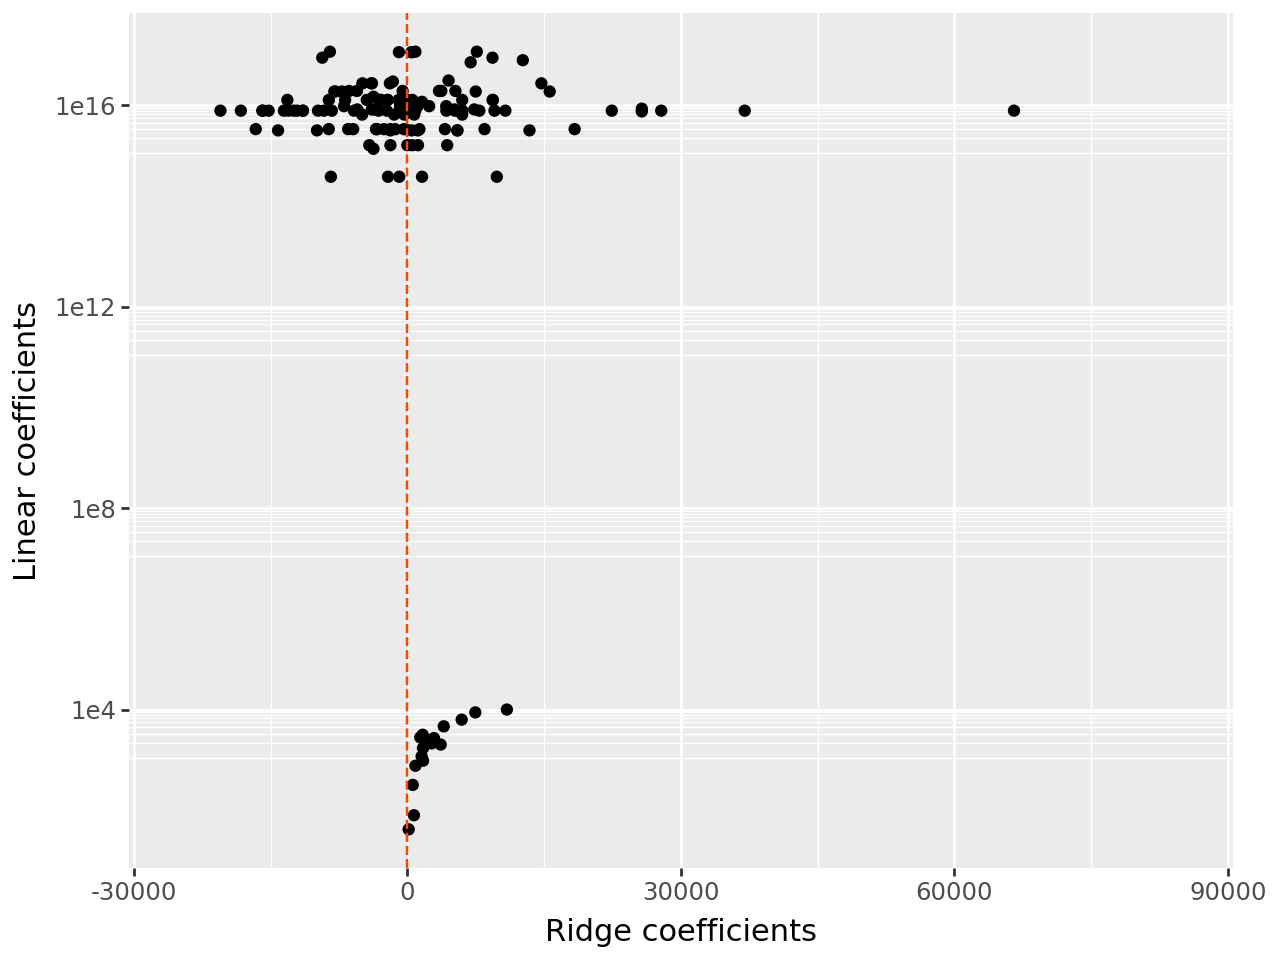

In [55]:
# Make plot comparing the coefficients of the two models

# First, create a dataframe for the plot
coefs_df = pd.DataFrame(
    {"ridge_coefs": ridge_coefs,
     "lr_coefs": lr_coefs}
)

# Now make the actual plot
from plotnine import *
(ggplot(coefs_df,
aes(
  x = "ridge_coefs",
  y = "lr_coefs"
))
+ geom_point()
+ labs(x="Ridge coefficients", y="Linear coefficients")
+ geom_vline(xintercept=0, linetype="dashed", color="orangered")
+ scale_x_continuous(limits=(-25000, 85000)) # this reflects the approximate range of Ridge coefficients
+ scale_y_log10()
 )

## 14.2.1: Tuning

In [56]:
# Tune the λ for the Ridge regression
from sklearn.model_selection import GridSearchCV

param_grid = {
    "ridge_regression__alpha": [0.001, 0.01, 0.1, 1, 10]
}

gscv = GridSearchCV(ridge_pipeline, param_grid, cv = 5, scoring="r2")
gscv_fitted = gscv.fit(X, y)
gscv_fitted.cv_results_["mean_test_score"]

array([0.85392021, 0.85418638, 0.85630206, 0.86193163, 0.86427221])


Based on this tuning procedure, it seems that λ=10 is the best option as it produced the highest average R-squared value, though the rest also performed almost as strongly.


## 14.3.1: LASSO

In [57]:
# Create LASSO pipeline and tune λ

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning) # ConvergenceWarnings are creating noisy output

lasso_pipeline = Pipeline(
  [("preprocessing", ct),
  ("lasso", Lasso())]
)

param_grid = {
    "lasso__alpha": [0.001, 0.01, 0.1, 1, 10]
}

gscv = GridSearchCV(lasso_pipeline, param_grid, cv = 5, scoring="r2")
gscv_fitted = gscv.fit(X, y)
gscv_fitted.cv_results_["mean_test_score"]

array([0.85549892, 0.85560578, 0.85661828, 0.85715222, 0.86063224])

In [58]:
# The model with λ=10 proved to be the best here, so we will fit that model on the full dataset

lasso_pipeline_best = Pipeline(
  [("preprocessing", ct),
  ("lasso", Lasso(alpha=10))]
)

lasso_pipeline_best_fitted = lasso_pipeline_best.fit(X, y)
lasso_coefs = lasso_pipeline_best_fitted.named_steps["lasso"].coef_

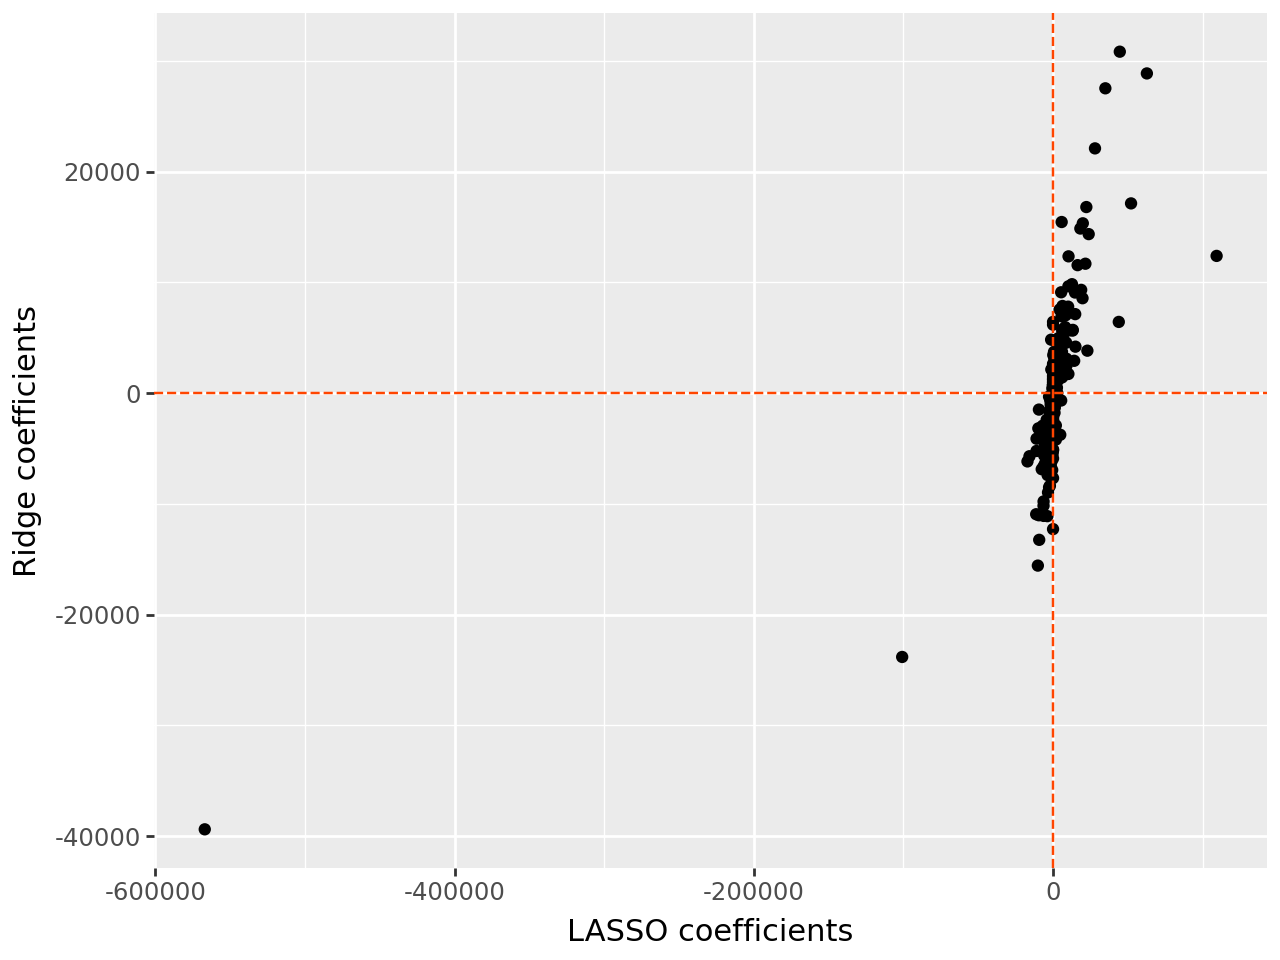

In [59]:
# Compare LASSO coefficients with Ridge coefficients (using the best λ for both)

# Update and re-fit Ridge pipeline with best λ (which was earlier found to be 10)
ridge_pipeline_new = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", Ridge(alpha=10))]
)
ridge_pipeline_fitted_new = ridge_pipeline_new.fit(X, y)
ridge_coefs_new = ridge_pipeline_fitted_new.named_steps["ridge_regression"].coef_


coefs_df = pd.DataFrame(
    {"lasso_coefs": lasso_coefs,
     "ridge_coefs": ridge_coefs_new}
)

# Now make the actual plot
(ggplot(coefs_df,
aes(
  x = "lasso_coefs",
  y = "ridge_coefs"
))
+ geom_point()
+ labs(x="LASSO coefficients", y="Ridge coefficients")
+ geom_vline(xintercept=0, linetype="dashed", color="orangered")
+ geom_hline(yintercept=0, linetype="dashed", color="orangered")
)

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
/usr/local/lib/python3.10/dist-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 108 rows containing missing values.


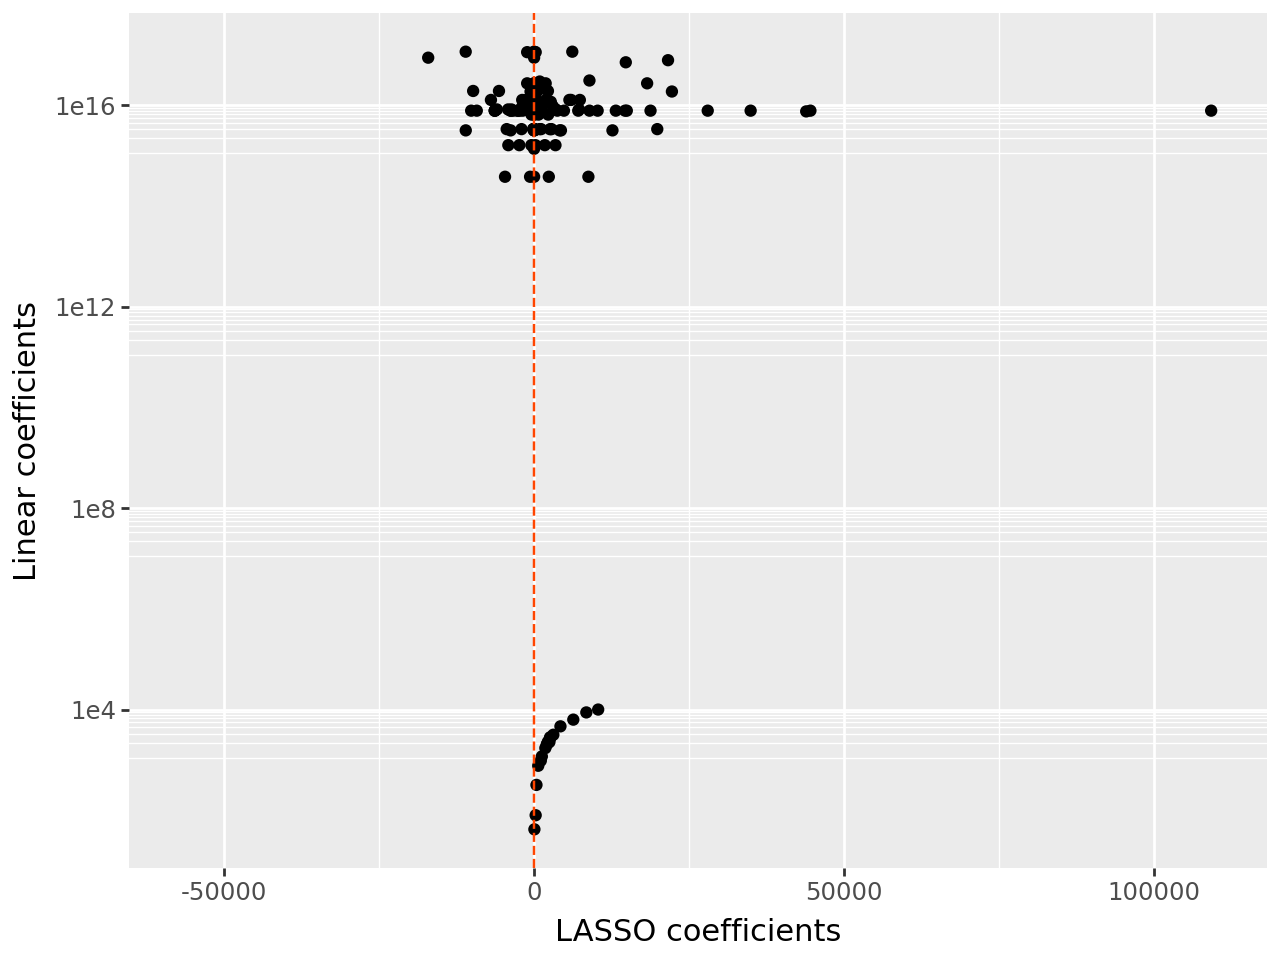

In [60]:
# Compare LASSO coefficients with linear
coefs_df = pd.DataFrame(
    {"lasso_coefs": lasso_coefs,
     "lr_coefs": lr_coefs}
)

# Now make the actual plot
(ggplot(coefs_df,
aes(
  x = "lasso_coefs",
  y = "lr_coefs"
))
+ geom_point()
+ labs(x="LASSO coefficients", y="Linear coefficients")
+ geom_vline(xintercept=0, linetype="dashed", color="orangered")
+ scale_x_continuous(limits=(-57000, 110000)) # this reflects the approximate range of LASSO coefficients
+ scale_y_log10()
)


There is obviously way more similarity between the LASSO and Ridge coefficients than between the LASSO and linear regression coefficients. This aligns with what we've found earlier, which is that while the LASSO and Ridge models fit the data very well (especially when tuned to find the best parameters), the linear regression model was overfit and performed very poorly.


## 14.3.3: Elastic Net

In [61]:
# Create Elastic Net pipeline and tune λ and α
elastic_net_pipeline = Pipeline(
  [("preprocessing", ct),
  ("elastic_net", ElasticNet())]
)

param_grid = {
    "elastic_net__alpha": [0.001, 0.01, 0.1, 1, 10],
    "elastic_net__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
}

gscv = GridSearchCV(elastic_net_pipeline, param_grid, cv=5, scoring="r2")
gscv_fitted = gscv.fit(X, y)

print("Best parameters:", gscv_fitted.best_params_)
print("Best R-squared score:", gscv_fitted.best_score_)

Best parameters: {'elastic_net__alpha': 0.01, 'elastic_net__l1_ratio': 0.5}
Best R-squared score: 0.8642678883652006


In [62]:
# Fit Elastic Net pipeline with best params (λ=0.01, α=0.5) on full dataset
elastic_net_pipeline_best = Pipeline(
  [("preprocessing", ct),
  ("elastic_net", ElasticNet(alpha=0.01, l1_ratio=0.5))]
)

elastic_net_pipeline_best_fitted = elastic_net_pipeline_best.fit(X, y)
elastic_net_coefs = elastic_net_pipeline_best_fitted.named_steps["elastic_net"].coef_

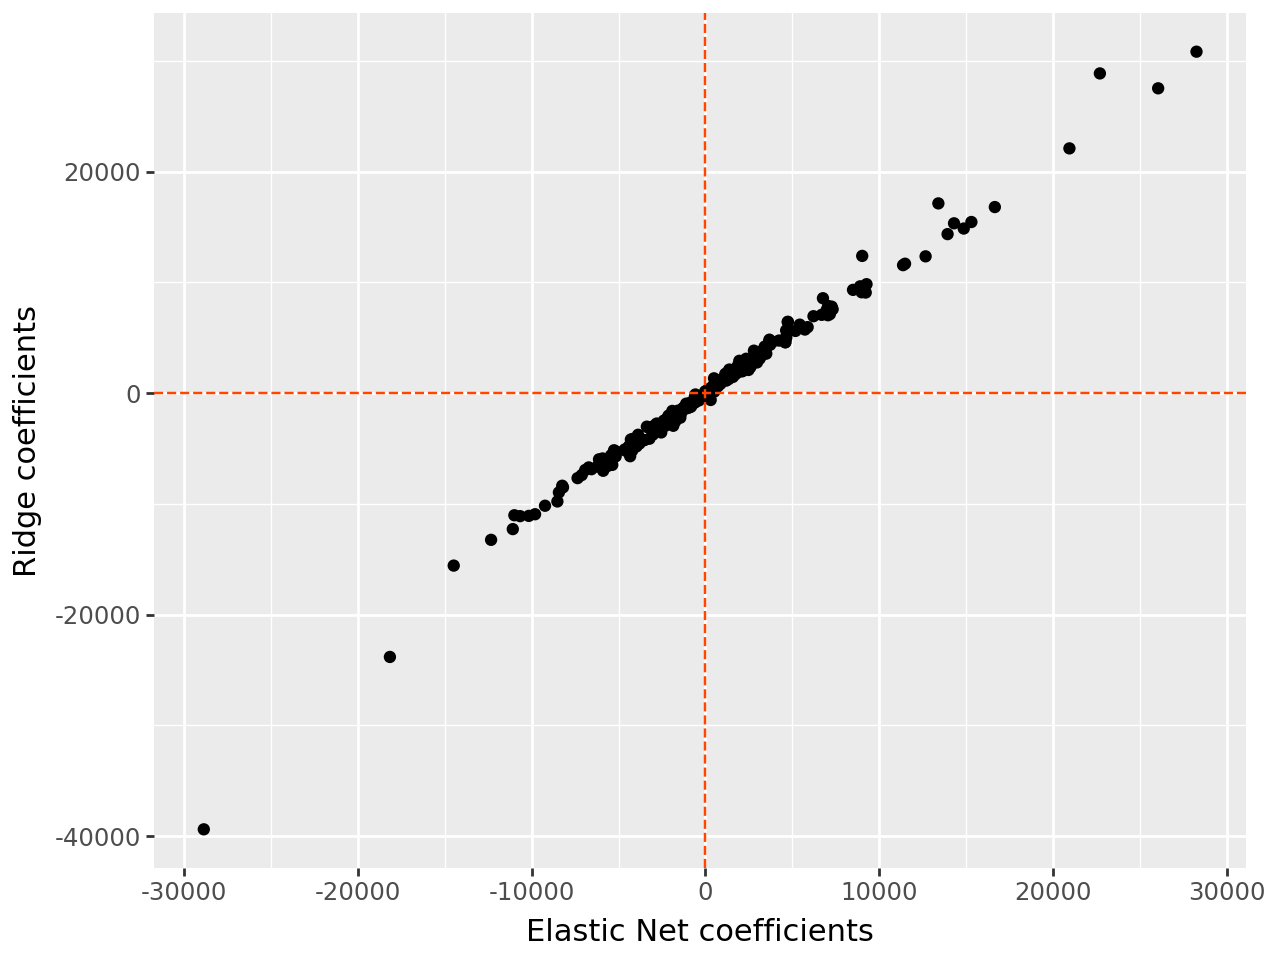

In [63]:
# Compare Elastic Net coefficients with Ridge
coefs_df = pd.DataFrame(
    {"elastic_net_coefs": elastic_net_coefs,
     "ridge_coefs": ridge_coefs_new}
)

# Now make the actual plot
(ggplot(coefs_df,
aes(
  x = "elastic_net_coefs",
  y = "ridge_coefs"
))
+ geom_point()
+ labs(x="Elastic Net coefficients", y="Ridge coefficients")
+ geom_vline(xintercept=0, linetype="dashed", color="orangered")
+ geom_hline(yintercept=0, linetype="dashed", color="orangered")
)

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
/usr/local/lib/python3.10/dist-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 108 rows containing missing values.


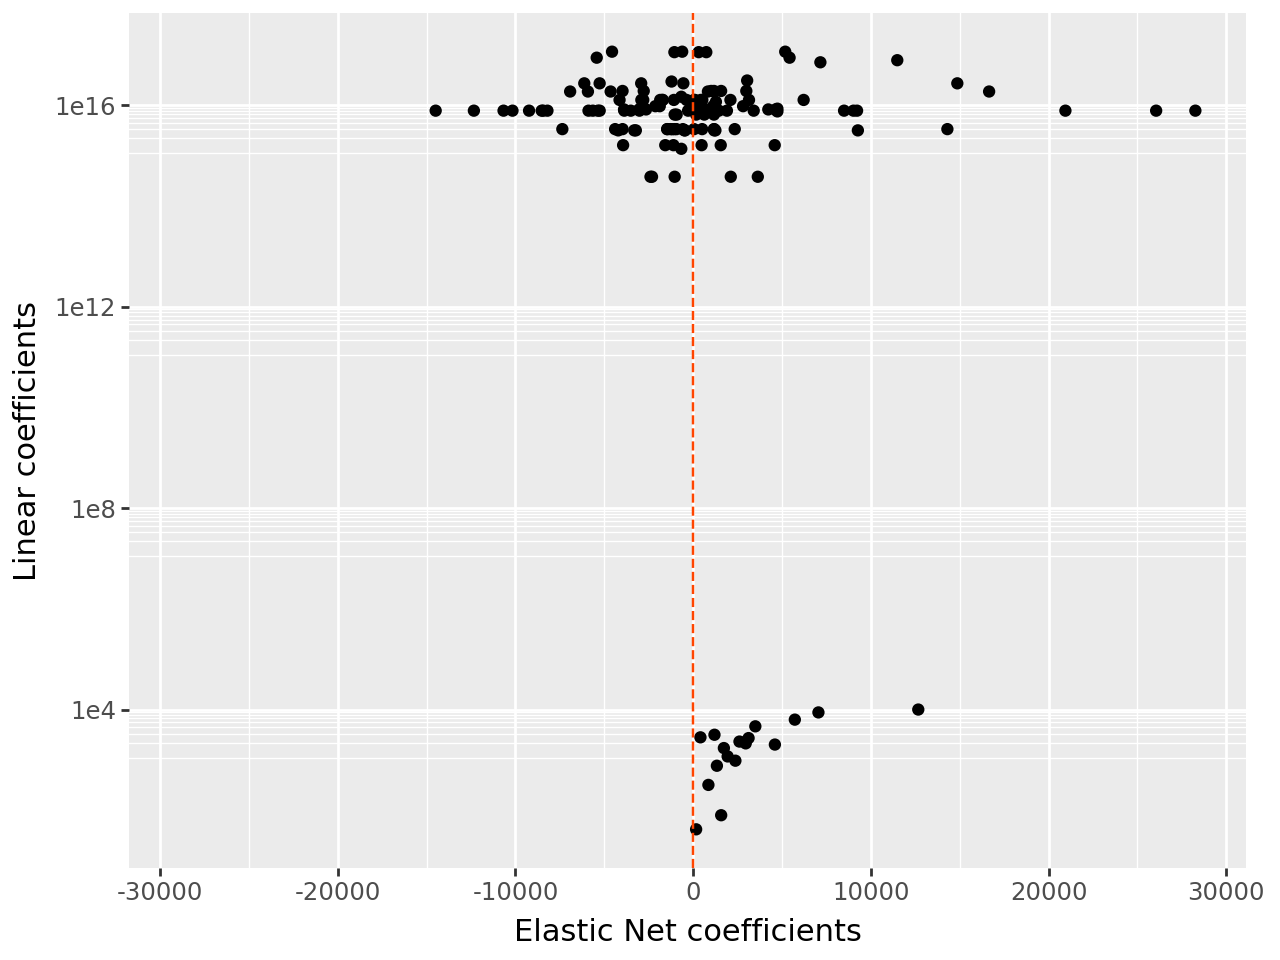

In [64]:
# Compare Elastic Net coefficients with linear
coefs_df = pd.DataFrame(
    {"elastic_net_coefs": elastic_net_coefs,
     "lr_coefs": lr_coefs}
)

# Now make the actual plot
(ggplot(coefs_df,
aes(
  x = "elastic_net_coefs",
  y = "lr_coefs"
))
+ geom_point()
+ labs(x="Elastic Net coefficients", y="Linear coefficients")
+ geom_vline(xintercept=0, linetype="dashed", color="orangered")
+ scale_y_log10()
)


When comparing the Elastic Net coefficients to both Ridge and linear coefficients, it becomes clear that the Ridge coefficients are much more similar to the Elastic Net coefficients than the linear coefficients are. This makes sense, given that the linear regression model was found to have fit the data very poorly and produced nonsensical predictions, while the Elastic Net and Ridge regression models did much better.
